In [ ]:
# https://www.kaggle.com/code/andradaolteanu/pytorch-rnns-and-lstms-explained-acc-0-99/notebook
# https://discuss.pytorch.org/t/video-classification-with-cnn-lstm/113413/4
# exactly my problem: https://discuss.pytorch.org/t/dataloader-for-multiple-input-images-in-one-training-example/68842/3
# classification tutorial: https://pytorchvideo.org/docs/tutorial_classification
# look into pytorch LSTM: https://cnvrg.io/pytorch-lstm/
# https://discuss.pytorch.org/t/how-to-define-and-train-cnn-lstm-many-to-one/74829/2

In [1]:
# own
import collector
import action
import world
import plot
import preprocess
import nets
import train

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


In [2]:
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from tqdm.auto import tqdm

In [22]:
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

In [23]:
import random

def split_data(data, train_set_perc=0.8, shuffle=True, length_trajectory=10):
    '''
    Splits dataset into training and test set.
    Returns training and test set.
    '''

    length = len(data['actions'])/length_trajectory
    absolute_split = length*train_set_perc
    
    def chunks(lst):
        n = length_trajectory
        chunked_lst = []
        for i in range(0, len(lst), n):
            chunked_lst.append(lst[i:i + n])
            
        return chunked_lst

    if shuffle:
        key_list = list(data.keys())
        seed = random.random()

        for i in key_list:
            data_i = data.pop(i)
            data_i = chunks(data_i)
            #print(data_i)
            random.seed(seed)
            random.shuffle(data_i)
            data[i] = data_i

    train_data = {}
    test_data = {}

    for i in data.keys():
        col_train = []
        col_test = []
        for index, val in enumerate(data[i]):
            if index < absolute_split:
                col_train.append(val)
            else:
                col_test.append(val)
        train_data[str(i)] = col_train
        test_data[str(i)] = col_test

    return train_data, test_data

In [24]:
def process_trajectory(data):
    images_unprocessed = data['observations']
    pos_trajectories = data['positions']

    img_trajectories = []

    for images in images_unprocessed:
        image_trajectory = []
        for image in images:
            image = torch.from_numpy(image).float()
            image = image.permute(2, 0, 1)
            image_trajectory.append(image)
        img_trajectories.append(image_trajectory)
    
    return img_trajectories, pos_trajectories

In [25]:
# we cannot shuffle the data here!

# IMPORTANT: possibly look into creating more at a later point in time
length_trajectory = 10
train_data, test_data = split_data(oracle_reversed_data, 0.8, length_trajectory)

In [26]:
train_imgs, train_pos = process_trajectory(train_data)
test_imgs, test_pos = process_trajectory(test_data)

In [27]:
class ObtainDataset(Dataset):
    '''
    Inherits functionality from Torch dataset.
    Required dict keys to load associated data.
    '''
    def __init__(self, images, labels, transform=None, target_transform=None):
        self.imgs = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # the method returns a pair: given - label for the index number i
        labels = self.labels[idx]
        images = self.imgs[idx]
        if self.transform:
            images = self.transform(images)
        if self.target_transform:
            labels = self.target_transform(labels)
        return images, labels

In [28]:
train_data = ObtainDataset(train_imgs, train_pos)
test_data = ObtainDataset(test_imgs, test_pos)

In [29]:
# preprocess trainingset 
batch_size = 128
dataset_loader_train_data = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataset_loader_test_data = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [64]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.conv3 = nn.Conv2d(20, 30, 5)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, i):
        #x = i.view(-1, i.shape[2], i.shape[3], i.shape[4])
        x = i.reshape(-1, i.shape[2], i.shape[3], i.shape[4])
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(i.shape[0], i.shape[1], -1)
        return x

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(480, 100, 2)
        self.fc = nn.Linear(100*10, length_trajectory)
    
    def forward(self, x, hn, cn):
        x, (hn, cn) = self.lstm(x, (hn, cn))
        hn, cn = (hn, cn)
        x = F.relu(x.view(x.shape[0], -1))
        
        output0 = F.relu(self.fc(x))
        output1 = F.relu(self.fc(x))
        # alternatively we could just return the final hidde 
        return output0, output1, hn, cn
           
# initialize network
net_cnn = CNN()
net_lstm = LSTM()

# check network
h0 = torch.randn(2, 10, 100)
c0 = torch.randn(2, 10, 100)

x = torch.rand((64, 10, 3, 32, 32))
features = net_cnn(x)
out0, out1, hidden, c = net_lstm(features, h0, c0)

# shape statistics
print('input cnn:', x.shape, '- Batch size, Channel out, Height out, Width out')
print('output cnn/ input lstm:', features.shape, " - Batch size, sequence length, input size")
print('output lstm:', out0.shape)
print('hidden lstm:', hidden[0].shape)

# network summary
print(summary(net_cnn, (64, 10, 3, 32, 32)))
print(summary(net_lstm, ((64, 10, 480), (2, 10, 100), (2, 10, 100))))

input cnn: torch.Size([64, 10, 3, 32, 32]) - Batch size, Channel out, Height out, Width out
output cnn/ input lstm: torch.Size([64, 10, 480])  - Batch size, sequence length, input size
output lstm: torch.Size([64, 10])
hidden lstm: torch.Size([10, 100])
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10, 480]             --
├─Conv2d: 1-1                            [640, 10, 28, 28]         760
├─Conv2d: 1-2                            [640, 20, 24, 24]         5,020
├─MaxPool2d: 1-3                         [640, 20, 12, 12]         --
├─Conv2d: 1-4                            [640, 30, 8, 8]           15,030
├─MaxPool2d: 1-5                         [640, 30, 4, 4]           --
Total params: 20,810
Trainable params: 20,810
Non-trainable params: 0
Total mult-adds (G): 2.85
Input size (MB): 7.86
Forward/backward pass size (MB): 108.95
Params size (MB): 0.08
Estimated Total Size (MB): 116.90
Layer (type:depth-idx)      

In [65]:
# to-do: implement dual output! since we want to predict the labels!
# get target values (y1, _, y2)
# we want output: 64, 10, 2

In [66]:
def train(train_data, val_data, net_cnn, net_lstm, criterion, optimizer, steps):
    '''
    Main training loop
    Input: dataset_loader, network, training_loss, optimizer, step size
    Output: trained network
    '''
    
    train_loss = []
    test_loss = []

    train_acc = []
    test_acc = []

    train_distances = []
    test_distances = []

    train_distances_itemwise = []
    test_distances_itemwise = []
    
    h = torch.randn(2, length_trajectory, 100)
    c = torch.randn(2, length_trajectory, 100)

    with tqdm(total=steps, unit =" Episode", desc ="Progress") as pbar:
        for epoch in range(steps):  # loop over the dataset multiple times

            train_running_loss = 0.0

            for i, data in enumerate(train_data, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, label = next(iter(dataset_loader_train_data))
                
                # https://discuss.pytorch.org/t/how-to-turn-a-list-of-tensor-to-tensor/8868/4
                labels = torch.stack(label)
                labels = torch.swapaxes(labels, 0, 1)
                
                # get target values (y1, _, y2) from each of the 64*10 items
                labels_A, labels_B = [], []
                for items in labels:
                    label_A, label_B = [], []
                    for item in items:
                        label_A.append(item[0])
                        label_B.append(item[2])
                    label_A = torch.stack(label_A)
                    label_B = torch.stack(label_B)
                    labels_A.append(label_A)
                    labels_B.append(label_B)
                    
                labels_A = torch.stack(labels_A)
                labels_B = torch.stack(labels_B)
                inputs = torch.stack(inputs)
                inputs = torch.swapaxes(inputs, 0, 1)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                #opt = torch.rand((64, 10, 3, 32, 32))
                #print('shape of the optimal inputs', opt.shape)
                #print('shape of the network inputs', inputs.shape)
                encoded = net_cnn(inputs)
                outputs_A, outputs_B, h, c = net_lstm(encoded, h, c)
                outputs_A = outputs_A.double()
                outputs_B = outputs_B.double()

                # compute losses separatel
                loss_A = criterion(outputs_A.squeeze(), labels_A)
                loss_B = criterion(outputs_B.squeeze(), labels_B)

                loss = loss_A + loss_B
                loss.backward()
                optimizer.step()
                
                # compute train_distances
                train_distance_itemwise = torch.sqrt(torch.square(labels_A - outputs_A.squeeze()) + torch.square(labels_B - outputs_B.squeeze()))
                train_distance = torch.sum(train_distance_itemwise)
                train_distance = torch.div(train_distance, len(labels_A)*length_trajectory)

                # track loss statistics
                train_running_loss += loss.item()

                test_running_loss = 0.0
                test_correct = 0
                test_total = 0

                # same for validation set
                with torch.no_grad():
                    for data in val_data:
                        
                        # get the inputs; data is a list of [inputs, labels]
                        inputs, label = next(iter(dataset_loader_test_data))

                        # https://discuss.pytorch.org/t/how-to-turn-a-list-of-tensor-to-tensor/8868/4
                        labels = torch.stack(label)
                        labels = torch.swapaxes(labels, 0, 1)

                        # get target values (y1, _, y2) from each of the 10
                        labels_A, labels_B = [], []
                        for items in labels:
                            label_A, label_B = [], []
                            for item in items:
                                label_A.append(item[0])
                                label_B.append(item[2])
                            label_A = torch.stack(label_A)
                            label_B = torch.stack(label_B)
                            labels_A.append(label_A)
                            labels_B.append(label_B)
                        labels_A = torch.stack(labels_A)
                        labels_B = torch.stack(labels_B)

                        inputs = torch.stack(inputs)
                        inputs = torch.swapaxes(inputs, 0, 1)

                        encoded = net_cnn(inputs)
                        outputs_A, outputs_B, h, c = net_lstm(encoded, h, c)
                        outputs_A = outputs_A.double()
                        outputs_B = outputs_B.double()

                        loss_A = criterion(outputs_A.squeeze(), labels_A)
                        loss_B = criterion(outputs_B.squeeze(), labels_B)

                        loss = loss_A + loss_B
                        test_running_loss += loss.item()
                        
                        # compute test_distances
                        test_distance_itemwise = torch.sqrt(torch.square(labels_A - outputs_A.squeeze()) + torch.square(labels_B - outputs_B.squeeze()))
                        test_distance = torch.sum(test_distance_itemwise)
                        test_distance = torch.div(test_distance, len(labels_A)*length_trajectory).numpy()

                        
            train_loss.append(train_running_loss/len(train_data)*10)
            test_loss.append(test_running_loss/len(val_data)*10)

            train_distances.append(train_distance)
            test_distances.append(test_distance)

            train_distances_itemwise.append(train_distance_itemwise)
            test_distances_itemwise.append(test_distance_itemwise)

            pbar.update(1)

            if epoch % 10 == 0:
                print(f'Epoch: {epoch + 1}, Train Loss: {(train_running_loss/len(train_data)):.4}, Train distance: {train_distance:.4}, , Test distance: {test_distance:.4}')
    print('Finished Training')
    
    return train_loss, test_loss, train_distances, test_distances, train_distances_itemwise, test_distances_itemwise

In [68]:
criterion = nn.MSELoss()
params = list(net_cnn.parameters()) + list(net_lstm.parameters())
optimizer = optim.Adam(params, lr=0.0001)
episodes = 500

train_loss, test_loss, train_dis, test_dis, train_dis_item, test_dis_item  = train(dataset_loader_train_data, dataset_loader_test_data,
                                                                                   net_cnn, net_lstm, criterion, optimizer, episodes)

#network,train_loss, test_loss, train_acc, test_acc = train(dataset_loader_train_data, dataset_loader_test_data, net_cnn, net_lstm, criterion, optimizer, steps)

Progress:   0%|          | 0/500 [00:00<?, ? Episode/s]

Epoch: 1, Train Loss: 515.5, Train distance: 22.17, , Test distance: 20.46
Epoch: 11, Train Loss: 502.1, Train distance: 21.53, , Test distance: 20.36
Epoch: 21, Train Loss: 481.4, Train distance: 21.07, , Test distance: 19.65
Epoch: 31, Train Loss: 378.2, Train distance: 18.61, , Test distance: 17.4
Epoch: 41, Train Loss: 307.3, Train distance: 16.43, , Test distance: 15.01
Epoch: 51, Train Loss: 240.7, Train distance: 14.42, , Test distance: 13.06
Epoch: 61, Train Loss: 204.1, Train distance: 13.2, , Test distance: 11.72
Epoch: 71, Train Loss: 174.2, Train distance: 12.13, , Test distance: 10.89
Epoch: 81, Train Loss: 154.9, Train distance: 11.37, , Test distance: 10.43
Epoch: 91, Train Loss: 148.0, Train distance: 11.17, , Test distance: 10.19
Epoch: 101, Train Loss: 136.5, Train distance: 10.48, , Test distance: 10.08
Epoch: 111, Train Loss: 140.3, Train distance: 10.53, , Test distance: 10.03
Epoch: 121, Train Loss: 137.2, Train distance: 10.62, , Test distance: 10.01
Epoch: 131, 

In [69]:
# needs to be adopted to take into account that 64*10*1 values! (wrong dimensions?)
from statistics import mean

train_dis_notensor  = []
for i in train_dis:
    i = i.detach().numpy()
    i = i.item()
    train_dis_notensor.append(i)
    
test_dis_notensor  = []
for i in test_dis:
    test_dis_notensor.append(float(i))
    
train_dis_item_notensor  = []
for i in train_dis_item:
    i = i.detach().numpy()
    train_dis_item_notensor.extend(i)

test_dis_item_notensor  = []
for i in test_dis_item:
    i = i.detach().numpy()
    test_dis_item_notensor.extend(i)
    
values = []
for packs in test_dis_item_notensor:
    values.append(mean(packs))

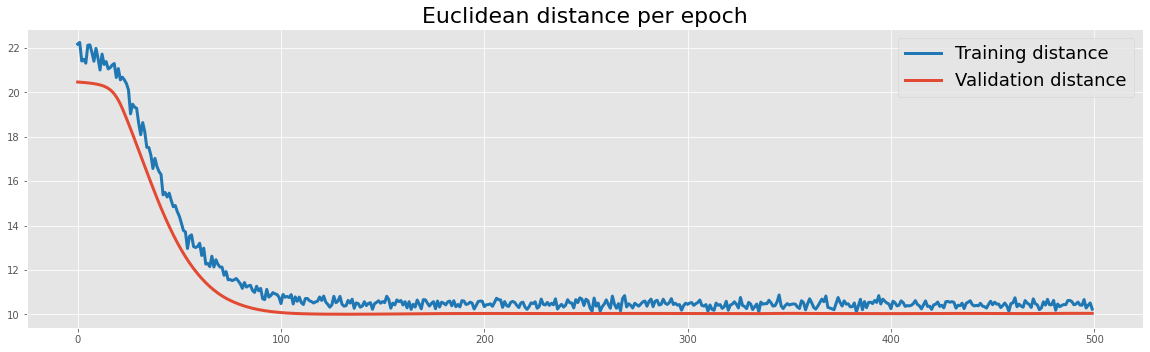

In [70]:
import torch

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 20, 5.5
    
with plt.style.context('ggplot'):
    plt.plot(train_dis_notensor[:], label = "Training distance", linewidth=3, color='tab:blue')
    plt.plot(test_dis_notensor[:], label = "Validation distance", linewidth=3)
    plt.title('Euclidean distance per epoch', fontsize=22)
    plt.legend(fontsize=18)
    plt.show()

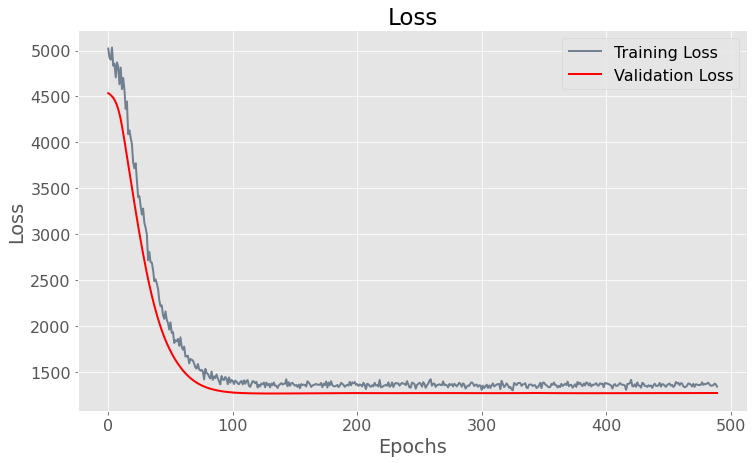

In [71]:
plot.plot_losses(train_loss[10:], test_loss[10:])

In [ ]:
# many-to-one: https://stackoverflow.com/questions/59381695/lstm-in-pytorch-how-to-add-change-sequence-length-dimension

